# Clasificador Bayesiano "Ingenuo"

## Formalismo matemático

El clasificador bayesiano busca la probabilidad de la etiqueta $y$ dado el ejemplo $x$, es decir $P(y|x)$. Usando el teorema de Bayes podemos escribir esto como

$$
p(y | x) = \frac{p(x|y) p(y)}{p(x)} = \frac{p(x|y) p(y)}{\sum_{y\in\mathcal{Y}} p(x|y) p(y)}
$$

donde

- $p(y)$ es la probabilidad *a priori*, corresponde a lo que sabemos antes de observar el ejemplo
- $p(y|x)$ es la probabilidad *a posteriori*, corresponde a lo que sabemos luego de observar el ejemplo $x$
- $p(x|y)$ es la verosimilitud de observar un ejemplo con atributos $x$ suponiendo que la etiqueta es $y$

Si tenemos un problema de clasificación binario, es decir con dos etiquetas, podemos escribir

$$
\frac{p(y=1|x)}{p(y=0|x)} = \frac{p(x|y=1) p(y=1)}{p(x|y=0) p(y=0)}
$$

Si el cociente anterior es mayor que $1$ entonces la clase de $x$ es $1$, de lo contrario es $0$. Si tenemos un problema de clasificación con $C$ clases entonces decidimos la clase con

$$
\hat y = \text{arg}\max_{k=1,\ldots,C} p(x|y=k) p(y=k)
$$

En ambos casos el denominador del teorema de Bayes no se ocupa, pues es idéntico para todo $y$. Por otro lado el *prior* suele estimarse empíricamente a partir de la base de datos de entrenamiento como

$$
p(y=k) = \frac{\text{Cantidad de ejemplos con etiqueta k}}{\text{Cantidad de ejemplos}}
$$

En términos prácticos la principal ventaja de este clasificador es que es simple, fácil de entrenar y muy difícil de sobreajustar. Su mayor desventaja es que hace supuestos muy fuertes sobre los datos. Si no se cumplen el desempeño no será bueno. 


## Supuestos "ingenuos"

Sea $x$ un vector que representa $D$ atributos. El primer supuesto del clasificador bayesiano ingenuo es que los atributos **son independientes**. Por lo tanto la verosimilitud se puede escribir como

$$
p(x|y) = \prod_{d=1}^D p(x_d|y)
$$

En segundo lugar se debe suponer una distribución para los atributos. Por ejemplo si asumimos una distribución Gaussiana 

$$
p(x_d|y) = \mathcal{N}(\mu_d, \sigma_d^2)
$$

se tiene un clasificador bayesiano ingenuo con verosimilitud Gaussiana. Se pueden suponer otras distribuciones dependiendo de los datos

- La distribución Gaussiana es típicamente usada para atributos continuos
- Para atributos discretos se puede usar la distribución multinomial

## Ejemplo: Clasificación de biopsias

En este ejemplo implementaremos un clasificador bayesiano ingenuo con verosimilitud gaussiana y lo entrenaremos usando el dataset de [cancer de mama de la Universidad de Wisconsin](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)). 

Para simplificar utilizaremos sólo dos atributos por paciente

- x: radio de la muestra (valor continuo)
- z: textura de la muestra (valor continuo)

Adicionalmente la variable $y$ se refiere a la etiqueta de la muestra. El dataset tiene 569 pacientes, 212 con tumores malignos (1) y 357 tumores benignos (0)

Importemos los datos y analicemos un gráfico de dispersión de los atributos. Reflexione ¿Son los datos separables?

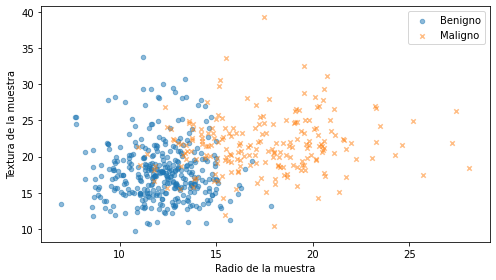

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import pandas as pd

df = pd.read_csv('data/cancer.csv', index_col=0)
x, y = df.drop(columns="diagnosis").values, df["diagnosis"].replace({'M':1, 'B':0}). values

fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
for k, (label, marker) in enumerate(zip(['Benigno', 'Maligno'], ['o', 'x'])):
    ax.scatter(x[y==k, 0], x[y==k, 1], s=20, marker=marker, label=label, alpha=0.5)
ax.set_xlabel('Radio de la muestra')
ax.set_ylabel('Textura de la muestra')
plt.legend();

Al ser un problema de clasificación binaria podemos escribir

$$
\frac{p(y=1|x, z)}{p(y=0|x, z)} = \frac{p(x|y=1) p(z|y=1) p(y=1)}{p(x|y=0) p(z|y=0) p(y=0)}
$$

En primer lugar estiamos los *priors* en base a la frecuencia de casos benignos y malignos en el dataset, es decir

$$
p(y=1) = \frac{212}{569} \approx 0.41
$$

y

$$
p(y=0) = \frac{357}{569} \approx 0.59
$$

In [4]:
from collections import Counter

print(Counter(y))
py = [Counter(y)[i]/len(y) for i in range(2)]

Counter({0: 357, 1: 212})


Ahora sólo falta encontrar los parámetros $\mu_x, \sigma_x, \mu_z, \sigma_z$. Los podemos encontrar aplicando el criterio de máxima verosimilitud sobre una distribución normal univariada mediante `scipy.stats.norm.fit`

In [5]:
import scipy.stats

dists = {}
for y_ in [0, 1]: # Para cada clase
    for d in [0, 1]: # para cada característica
        params = scipy.stats.norm.fit(x[y==y_, d])
        dists[(y_, d)] = scipy.stats.norm(loc=params[-2], scale=params[-1])

El siguiente gráfico de contornos muestra el resultado del ajuste para las distribuciones de los pacientes sanos y con cancer 

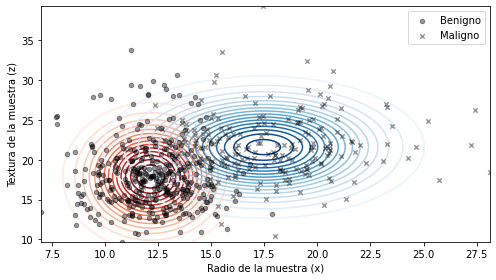

In [8]:
def verosimilitud_y_cociente(x, z):
    pxzy0 = dists[(0, 0)].pdf(x)*dists[(0, 1)].pdf(z)
    pxzy1 = dists[(1, 0)].pdf(x)*dists[(1, 1)].pdf(z)
    return pxzy0, pxzy1, (pxzy1*py[1])/(pxzy0*py[0] + 1e-8)

fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
for k, (label, marker) in enumerate(zip(['Benigno', 'Maligno'], ['o', 'x'])):
    ax.scatter(x[y==k, 0], x[y==k, 1], c='k', s=20, 
               marker=marker, label=label, alpha=0.4)

x_plot = np.linspace(np.amin(x[:, 0]), np.amax(x[:, 0]), num=500)
z_plot = np.linspace(np.amin(x[:, 1]), np.amax(x[:, 1]), num=500)
X, Z = np.meshgrid(x_plot, z_plot)
Y = verosimilitud_y_cociente(X, Z)
ax.contour(X, Z, Y[0], zorder=-1, cmap=plt.cm.Reds, levels=20)
ax.contour(X, Z, Y[1], zorder=-1, cmap=plt.cm.Blues, levels=20)
ax.set_xlim([np.amin(x_plot), np.amax(x_plot)])
ax.set_ylim([np.amin(z_plot), np.amax(z_plot)])
ax.set_xlabel('Radio de la muestra (x)')
ax.set_ylabel('Textura de la muestra (z)')
plt.legend();

El último paso consiste en decidir entre benigno y maligno usando el cociente entre los posterior

En el caso binario es típico usar una regla como la siguiente

$$
\frac{p(y=1|x, z)}{p(y=0|x, z)} > R
$$

donde $R$ es un "umbral de clasificación". El siguiente gráfico muestra las fronteras de decisión usando cuatro umbrales distintos

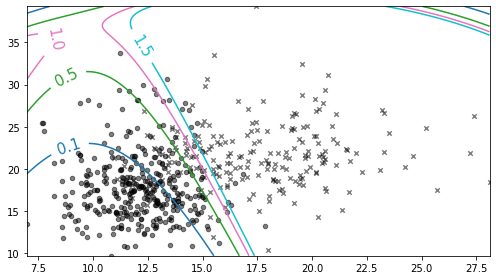

In [5]:
fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
for k, (label, marker) in enumerate(zip(['Benigno', 'Maligno'], ['o', 'x'])):
    ax.scatter(x[y==k, 0], x[y==k, 1], c='k', s=20, 
               marker=marker, label=label, alpha=0.5)

cp = ax.contour(X, Z, Y[2] ,  levels=[0.1, 0.5, 1., 1.5], cmap=plt.cm.tab10);
ax.clabel(cp, fontsize=15, fmt='%0.1f', manual=[(9.0, 35), (9.0, 30), (9.0, 22), (12.5, 35)]);

Podemos "ajustar" el riesgo $R$ para controlar el compromiso (trade-off) entre los siguientes tipos de errores

1. Falso positivo: Predecir que el paciente está enfermo $\hat y=1$ cuando en realidad estaba sano $y=0$
1. Falso negativo: Predecir que el paciente está sano $\hat y=0$ cuando en realidad estaba enfermo $y=1$

Reflexione: En un problema de índole médico como el que acabamos de revisar ¿Cuáles son las repercusiones de cada uno de estos errores? ¿Cuál es más grave?

## Clasificador bayesiano con  `scikit-learn`

A continuación se utiliza el módulo [`sklearn.naive_bayes`](https://scikit-learn.org/stable/modules/naive_bayes.html) que implementa distintos clasificadores bayesianos ingenuos, entre ellos

- Clasificador con verosimilitud Gaussiana: `GaussianNB`
- Clasificador con verosimilitud Multinomial: `MultinomialNB`

Por ejemplo el constructor de `GaussianNB` es

```python
sklearn.naive_bayes.GaussianNB(priors=None, # Un ndarray con las probabilidades a priori
                               ...
                              )
```

cuyos métodos más importantes son

- `fit(X, y)`: Ajusta el modelo a un conjunto de datos `X` con etiqueta `y`
- `predict_proba(X)`: Retorna la probabilidad de cada clase
- `predict(X)`: Retorna la clase de máxima probabilidad
- `score(X, y)`: Retorna la exactitud (*accuracy*) promedio del modelo



Usemos lo aprendido para entrenar el clasificador bayesiano en los datos del ejemplo anterior

In [6]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB(priors=py) #Usamos los priors calculados antes
clf.fit(x[:, :2], y) # Entrenamos

GaussianNB(priors=[0.6274165202108963, 0.37258347978910367])

Podemos uar el método `predict_proba` para visualizar la frontera de decisión

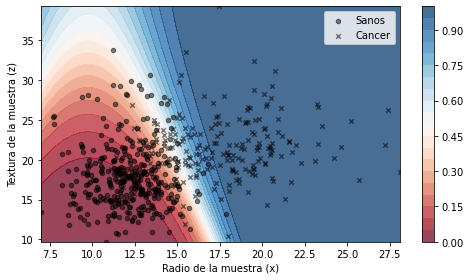

In [7]:
fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
for k, (label, marker) in enumerate(zip(['Sanos', 'Cancer'], ['o', 'x'])):
    ax.scatter(x[y==k, 0], x[y==k, 1], c='k', s=20, 
               marker=marker, label=label, alpha=0.5)

Y = clf.predict_proba(np.stack((X.ravel(), Z.ravel())).T)[:, 1]
#Y = clf.predict(np.stack((X.ravel(), Z.ravel())).T)

cf = ax.contourf(X, Z, np.reshape(Y, X.shape), zorder=-1, cmap=plt.cm.RdBu, vmin=0, vmax=1, levels=20, alpha=0.75)
ax.set_xlim([np.amin(x_plot), np.amax(x_plot)])
ax.set_ylim([np.amin(z_plot), np.amax(z_plot)])
ax.set_xlabel('Radio de la muestra (x)')
ax.set_ylabel('Textura de la muestra (z)')
plt.colorbar(cf)
plt.legend();

## Evaluando un clasificador

A continuación veremos como evaluar de manera cuantitativa el desempeño de un modelo clasificador

### Matriz o tabla de confusión

Una matriz o tabla de confusión se construye contando los casos que tienen etiqueta real igual a $i$ y etiqueta predicha igual a $j$ para $i \wedge j=1,2,\ldots,C$ donde $C$ es el número de clases

La siguiente imagen muestra una matriz de confusión para un problema de $10$ clases

<img src="img/conf-matrix.png" width="400">

En una matriz de confusión 

- los elementos de la diagonal representan las clasificaciones correctas
- los elementos fuera de la diagonal representan las clasificaciones erroneas
- las filas corresponden a las clases reales
- las columnas corresponden a las clases predichas por el clasificador

Ejemplo: En la imagen anterior tenemos $2$ ejemplos de clase "4" que fueron clasificados como clase "1" por el modelo


En `scikit-learn` podemos calcular la matriz de confusión usando el módulo [`sklearn.metrics`](https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics)

Notar que la matriz de confusión requiere una etiqueta categórica, es decir no acepta probabilidades. Podemos convertir probabilidades en etiquetas categóricas usando `np.argmax(probs, axis=1)`. También podemos usar el método `predict` para obtener la predicción categórica directamente.

In [8]:
from sklearn.metrics import confusion_matrix

yhat = clf.predict(x[:, :2])
cm = confusion_matrix(y,  # Etiqueta real
                      yhat # Etiqueta predicha
                     )
print(cm)

[[340  17]
 [ 48 164]]


También podemos usar el objeto [`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay) con sus métodos `from_estimator` o `from_prediction` si deseamos producir una matriz de confusión como una figura de `matplotlib`

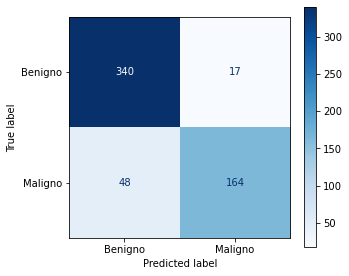

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(5, 4), tight_layout=True)

ConfusionMatrixDisplay.from_estimator(clf, x[:, :2], y, ax=ax, 
                                      display_labels=np.array(['Benigno', 'Maligno']), #Nombres de las clases
                                      cmap=plt.cm.Blues, # Escala de colores
                                      normalize=None #Permite escoger entre cantidades y porcentajes
                                     );

Intepretación: 

- Hay 17 casos predichos como maligno que en realidad eran benignos: **Falso positivo**
- Hay 48 casos predichos como benignos que en realidad eran malignos: **Falso negativo**



### Curvas de desempeño

La matriz de confusión y la exactitud son métricas que depende de un umbral de clasificación o punto de operación particular

En problemas de clasificación binaria es mucho más informativo medir el desempeño utilizando curvas Receiver operating characteristic (ROC)

Una curva ROC es la tasa de verdaderos positivos

$$
TPR = \frac{TP}{TP+FN}
$$

en función de la tasa de falsos positivos

$$
FPR = \frac{FP}{FP + TN}
$$

para distintos umbrales de clasificación $R$

Podemos obtenerla de forma simple utilizando `sklearn.metrics.roc_curve`

0.1569, 0.9057, 0.2137


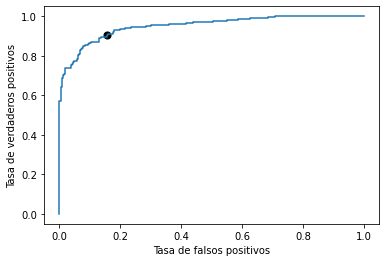

In [25]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y, clf.predict_proba(x[:, :2])[:, 1])
idx = np.where(tpr > 0.9)[0][0]
print(f"{fpr[idx]:0.4f}, {tpr[idx]:0.4f}, {thresholds[idx]:0.4f}")

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(fpr, tpr)
ax.scatter(fpr[idx], tpr[idx], s=50, c='k')
ax.set_xlabel('Tasa de falsos positivos')
ax.set_ylabel('Tasa de verdaderos positivos');

Mientras más apegada esté la curva al punto TPR=1 y FPR=0, mejor será el modelo. La curva ROC nos permite estudiar todos los puntos de operación a la vez y seleccionar aquel que sea más adecuado para la tarea particular

Por ejemplo la curva anterior nos dice que si usamos el umbral $R=0.2137$ (punto negro en la curva) tendremos una tasa de verdaderos positivos de ~91% y una tasa de falsos positivos de ~16%. Esto significa que en dicho punto de operación un ~9% de los pacientes que tienen un cancer maligno no serán pesquisados (falso negativo) mientras que un ~16%  de los pacientes que están sanos serán diagnosticados con cancer (falso positivo)

